<a href="https://colab.research.google.com/github/haraharaman/learning/blob/main/python100knocks/5%E7%AB%A0_%E9%A1%A7%E5%AE%A2%E3%81%AE%E9%80%80%E4%BC%9A%E3%82%92%E4%BA%88%E6%B8%AC%E3%81%99%E3%82%8B10%E6%9C%AC%E3%83%8E%E3%83%83%E3%82%AF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Google Driveと接続を行います。これを行うことで、Driveにあるデータにアクセスできるようになります。
# 下記セルを実行すると、Googleアカウントのログインを求められますのでログインしてください。
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 作業フォルダへの移動を行います。
# 人によって作業場所がことなるので、その場合作業場所を変更してください。
import os 
os.chdir('/content/drive/MyDrive/勉強/Colab Notebooks/100knock-data_analytics/5章') #ここを変更。

# 5章 顧客の退会を予測する１０本ノック

引き続き、スポーツジムの会員データを使って顧客の行動を分析していきます。  
３章では顧客の全体像を把握し、4章では数ヶ月利用している顧客の来月の利用回数の予測を行いました。   
ここでは、教師あり学習の分類を用いて、顧客の退会予測を取り扱います。

### ノック41：データを読み込んで利用データを整形しよう

In [3]:
import pandas as pd

log = pd.read_csv("use_log_months.csv")
customer = pd.read_csv("customer_join.csv")
customer

,customer_id,name,class,gender,start_date,end_date,campaign_id,is_deleted,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA832399,XXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,5.0,8,2,1,2019-04-30,47
1,PL270116,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,5.083333,5.0,7,3,1,2019-04-30,47
2,OA974876,XXXXX,C01,M,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.583333,5.0,6,3,1,2019-04-30,47
3,HD024127,XXXXX,C01,F,2015-05-01,NaN,CA1,0,オールタイム,10500,通常,4.833333,4.5,7,2,1,2019-04-30,47
4,HD661448,XXXXX,C03,F,2015-05-01,NaN,CA1,0,ナイト,6000,通常,3.916667,4.0,6,1,1,2019-04-30,47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4187,HD676663,XXXX,C01,M,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,8.000000,8.0,8,8,0,2019-04-30,1
4188,HD246549,XXXXX,C01,F,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,10.000000,10.0,10,10,0,2019-04-30,1
4189,GD037007,XXXXX,C03,M,2019-03-14,NaN,CA1,0,ナイト,6000,通常,8.000000,8.0,8,8,0,2019-04-30,1
4190,OA953150,XXXXX,C01,M,2019-03-14,NaN,CA1,0,オールタイム,10500,通常,11.000000,11.0,11,11,0,2019-04-30,1


In [4]:
#log["年月"] = pd.to_datetime(log["年月"])
#log["month"] = log["年月"].dt.strftime("%Y%m")
log_pivot = log.pivot_table(index="customer_id",columns="年月",values="count")
log_pivot


#前2か月分利用状況と当月の利用回数を集計
month = log_pivot.columns.values
data = pd.DataFrame()
for i in range(2,len(month)+1):
  tmp = log_pivot.iloc[:,i-2:i]
  tmp = tmp.assign(month= tmp.columns.values[1])
  tmp = tmp.set_axis(["cnt1","cnt2","年月"],axis=1)
  data = pd.concat([data,tmp])

#NaNを含むデータを削除
data = data.dropna()
data

,cnt1,cnt2,年月
customer_id,,,
AS002855,4.0,5.0,201805
AS009373,3.0,4.0,201805
AS015315,6.0,3.0,201805
AS015739,7.0,5.0,201805
AS015746,4.0,1.0,201805
...,...,...,...
TS995853,11.0,8.0,201903
TS998593,7.0,8.0,201903
TS999079,2.0,3.0,201903


### ノック42：退会前月の退会顧客データを作成しよう

In [5]:
from dateutil.relativedelta import relativedelta
#退会済み顧客の抽出
exit_customer = customer.loc[customer["is_deleted"]==1]

#退会月を抽出し、退会前月を算出
exit_customer = exit_customer.assign(exit_date = relativedelta(months=1))
exit_customer["exit_date"] = pd.to_datetime(exit_customer["end_date"]) - exit_customer["exit_date"]
exit_customer["年月"] = exit_customer["exit_date"].dt.strftime("%Y%m")

#退会月の抽出
exit_customer[["exit_date","年月"]]

<ipython-input-5-e025db6a2ede>:7: PerformanceWarning: Adding/subtracting object-dtype array to DatetimeArray not vectorized.
  exit_customer["exit_date"] = pd.to_datetime(exit_customer["end_date"]) - exit_customer["exit_date"]


,exit_date,年月
708,2018-03-30,201803
729,2018-03-30,201803
730,2018-03-30,201803
770,2018-04-30,201804
785,2018-04-30,201804
...,...,...
4049,2019-01-28,201901
4050,2019-02-28,201902
4068,2019-02-28,201902
4086,2019-02-28,201902


In [6]:
data["年月"] = data["年月"].astype(str)
exit_log = pd.merge(data, exit_customer, how = "left", on = ["customer_id","年月"])
exit_log = exit_log.dropna(subset="name")
exit_log

,customer_id,cnt1,cnt2,年月,name,class,gender,start_date,end_date,campaign_id,...,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date
16,AS055680,3.0,3.0,201805,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30
48,AS169823,3.0,2.0,201805,XX,C01,M,2017-11-01,2018-06-30,CA1,...,10500.0,通常,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30
98,AS305860,3.0,5.0,201805,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30
116,AS363699,3.0,5.0,201805,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,10500.0,通常,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30
133,AS417696,4.0,1.0,201805,XX,C03,F,2017-09-01,2018-06-30,CA1,...,6000.0,通常,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29625,TS645212,2.0,4.0,201902,XXXX,C03,F,2018-03-01,2019-03-31,CA1,...,6000.0,通常,4.500000,4.5,7.0,1.0,0.0,2019-03-31,12.0,2019-02-28
29654,TS741703,6.0,5.0,201902,XXXX,C03,M,2018-12-08,2019-03-31,CA3,...,6000.0,入会費無料,6.250000,6.0,8.0,5.0,0.0,2019-03-31,3.0,2019-02-28
29694,TS859258,3.0,1.0,201902,XXXXX,C02,F,2018-12-07,2019-03-31,CA3,...,7500.0,入会費無料,2.500000,2.0,5.0,1.0,0.0,2019-03-31,3.0,2019-02-28
29707,TS886985,3.0,5.0,201902,XXX,C02,F,2018-03-01,2019-03-31,CA1,...,7500.0,通常,4.250000,4.0,7.0,2.0,1.0,2019-03-31,12.0,2019-02-28


### ノック43：継続顧客のデータを作成しよう

In [7]:
#logデータと顧客データを結合
cont_customer = customer.loc[customer["is_deleted"]==0]
cont_log = pd.merge(data, cont_customer, how = "left", on = "customer_id")
cont_log = cont_log.dropna(subset="name")
cont_log

,customer_id,cnt1,cnt2,年月,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,AS002855,4.0,5.0,201805,XXXX,C03,F,2016-11-01,NaN,CA1,...,ナイト,6000.0,通常,4.500000,5.0,7.0,2.0,1.0,2019-04-30,29.0
1,AS009373,3.0,4.0,201805,XX,C01,F,2015-11-01,NaN,CA1,...,オールタイム,10500.0,通常,5.083333,5.0,7.0,3.0,1.0,2019-04-30,41.0
2,AS015315,6.0,3.0,201805,XXXXX,C01,M,2015-07-01,NaN,CA1,...,オールタイム,10500.0,通常,4.833333,5.0,7.0,3.0,1.0,2019-04-30,45.0
3,AS015739,7.0,5.0,201805,XXXXX,C03,M,2017-06-01,NaN,CA1,...,ナイト,6000.0,通常,5.583333,5.5,8.0,4.0,1.0,2019-04-30,22.0
5,AS019860,6.0,8.0,201805,XXXXXX,C03,F,2017-10-01,NaN,CA1,...,ナイト,6000.0,通常,6.083333,6.0,9.0,4.0,1.0,2019-04-30,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32645,TS995853,11.0,8.0,201903,XXXX,C01,M,2019-02-08,NaN,CA1,...,オールタイム,10500.0,通常,9.500000,9.5,11.0,8.0,1.0,2019-04-30,2.0
32646,TS998593,7.0,8.0,201903,XXXXX,C03,M,2018-09-01,NaN,CA1,...,ナイト,6000.0,通常,8.142857,8.0,9.0,7.0,1.0,2019-04-30,7.0
32647,TS999079,2.0,3.0,201903,XXX,C03,M,2016-06-01,NaN,CA1,...,ナイト,6000.0,通常,4.916667,5.5,9.0,2.0,1.0,2019-04-30,34.0
32648,TS999231,6.0,6.0,201903,XXXX,C01,M,2017-03-01,NaN,CA1,...,オールタイム,10500.0,通常,4.666667,5.0,8.0,1.0,1.0,2019-04-30,25.0


In [8]:
#結合したデータをシャッフル
cont_log2 = cont_log.sample(frac=1).reset_index(drop=True)
#customer_idが重複した行を削除
cont_log2 = cont_log2.drop_duplicates(subset="customer_id")
cont_log2

,customer_id,cnt1,cnt2,年月,name,class,gender,start_date,end_date,campaign_id,...,class_name,price,campaign_name,mean,median,max,min,routine_flg,calc_date,membership_period
0,OA297467,4.0,2.0,201806,XXXXX,C02,M,2016-02-01,NaN,CA1,...,デイタイム,7500.0,通常,4.000000,4.0,8.0,1.0,1.0,2019-04-30,38.0
1,IK810639,6.0,3.0,201808,XXX,C01,F,2016-02-01,NaN,CA1,...,オールタイム,10500.0,通常,3.916667,4.0,6.0,1.0,1.0,2019-04-30,38.0
2,IK166339,10.0,4.0,201809,XXXX,C01,M,2017-04-01,NaN,CA1,...,オールタイム,10500.0,通常,5.916667,5.0,10.0,3.0,1.0,2019-04-30,24.0
3,GD311895,8.0,6.0,201807,XXX,C01,F,2017-03-01,NaN,CA1,...,オールタイム,10500.0,通常,6.000000,6.0,8.0,4.0,1.0,2019-04-30,25.0
4,OA661244,7.0,6.0,201903,XXX,C01,M,2017-07-01,NaN,CA2,...,オールタイム,10500.0,入会費半額,6.500000,6.5,9.0,5.0,1.0,2019-04-30,21.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25523,HD044538,11.0,4.0,201903,XXXXX,C01,M,2019-02-10,NaN,CA1,...,オールタイム,10500.0,通常,7.500000,7.5,11.0,4.0,1.0,2019-04-30,2.0
25565,AS288237,8.0,9.0,201903,XXXXX,C01,M,2019-02-13,NaN,CA1,...,オールタイム,10500.0,通常,8.500000,8.5,9.0,8.0,1.0,2019-04-30,2.0
25921,TS614788,9.0,9.0,201903,XXXXX,C03,M,2019-02-07,NaN,CA1,...,ナイト,6000.0,通常,9.000000,9.0,9.0,9.0,1.0,2019-04-30,2.0
26015,GD546088,7.0,7.0,201903,XXXXXX,C01,F,2019-02-04,NaN,CA1,...,オールタイム,10500.0,通常,7.000000,7.0,7.0,7.0,1.0,2019-04-30,2.0


### ノック44：予測する月の在籍期間を作成しよう

In [9]:
#42と43のデータを結合
train_data = pd.concat([exit_log,cont_log2], ignore_index=True).reset_index(drop=True)
#datetime型に変換
train_data["start_date"] = pd.to_datetime(train_data["start_date"])
train_data["now_date"] = pd.to_datetime(train_data["年月"],format="%Y%m")
#初期化
train_data["period"] = None

#now_dateと_start_dateの差分をperiodに追加
for i in range(len(train_data)):
  delta = relativedelta(train_data.loc[i,"now_date"],train_data.loc[i,"start_date"])
  train_data.loc[i,"period"] = delta.years * 12 + delta.months 
train_data

,customer_id,cnt1,cnt2,年月,name,class,gender,start_date,end_date,campaign_id,...,mean,median,max,min,routine_flg,calc_date,membership_period,exit_date,now_date,period
0,AS055680,3.0,3.0,201805,XXXXX,C01,M,2018-03-01,2018-06-30,CA1,...,3.000000,3.0,3.0,3.0,0.0,2018-06-30,3.0,2018-05-30,2018-05-01,2
1,AS169823,3.0,2.0,201805,XX,C01,M,2017-11-01,2018-06-30,CA1,...,3.000000,3.0,4.0,2.0,1.0,2018-06-30,7.0,2018-05-30,2018-05-01,6
2,AS305860,3.0,5.0,201805,XXXX,C01,M,2017-06-01,2018-06-30,CA1,...,3.333333,3.0,5.0,2.0,0.0,2018-06-30,12.0,2018-05-30,2018-05-01,11
3,AS363699,3.0,5.0,201805,XXXXX,C01,M,2018-02-01,2018-06-30,CA1,...,3.333333,3.0,5.0,2.0,0.0,2018-06-30,4.0,2018-05-30,2018-05-01,3
4,AS417696,4.0,1.0,201805,XX,C03,F,2017-09-01,2018-06-30,CA1,...,2.000000,1.0,4.0,1.0,0.0,2018-06-30,9.0,2018-05-30,2018-05-01,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3824,HD044538,11.0,4.0,201903,XXXXX,C01,M,2019-02-10,NaN,CA1,...,7.500000,7.5,11.0,4.0,1.0,2019-04-30,2.0,NaT,2019-03-01,0
3825,AS288237,8.0,9.0,201903,XXXXX,C01,M,2019-02-13,NaN,CA1,...,8.500000,8.5,9.0,8.0,1.0,2019-04-30,2.0,NaT,2019-03-01,0
3826,TS614788,9.0,9.0,201903,XXXXX,C03,M,2019-02-07,NaN,CA1,...,9.000000,9.0,9.0,9.0,1.0,2019-04-30,2.0,NaT,2019-03-01,0
3827,GD546088,7.0,7.0,201903,XXXXXX,C01,F,2019-02-04,NaN,CA1,...,7.000000,7.0,7.0,7.0,1.0,2019-04-30,2.0,NaT,2019-03-01,0


### ノック45：欠損値を除去しよう

In [10]:
train_data.isna().sum()

customer_id             0
cnt1                    0
cnt2                    0
年月                      0
name                    0
class                   0
gender                  0
start_date              0
end_date             2777
campaign_id             0
is_deleted              0
class_name              0
price                   0
campaign_name           0
mean                    0
median                  0
max                     0
min                     0
routine_flg             0
calc_date               0
membership_period       0
exit_date            2777
now_date                0
period                  0
dtype: int64

In [11]:
train_data.dtypes

customer_id                  object
cnt1                        float64
cnt2                        float64
年月                           object
name                         object
class                        object
gender                       object
start_date           datetime64[ns]
end_date                     object
campaign_id                  object
is_deleted                  float64
class_name                   object
price                       float64
campaign_name                object
mean                        float64
median                      float64
max                         float64
min                         float64
routine_flg                 float64
calc_date                    object
membership_period           float64
exit_date            datetime64[ns]
now_date             datetime64[ns]
period                       object
dtype: object

### ノック46：文字列型の変数を処理できるように整形しよう

In [12]:
train = train_data[["cnt1","cnt2","class_name","gender","campaign_name","period","routine_flg","is_deleted"]]
#periodをint型に変換
train = train.copy() #コピーしないと、なんかwarningがでる
train["period"] = train["period"].astype(int)
train

,cnt1,cnt2,class_name,gender,campaign_name,period,routine_flg,is_deleted
0,3.0,3.0,オールタイム,M,通常,2,0.0,1.0
1,3.0,2.0,オールタイム,M,通常,6,1.0,1.0
2,3.0,5.0,オールタイム,M,通常,11,0.0,1.0
3,3.0,5.0,オールタイム,M,通常,3,0.0,1.0
4,4.0,1.0,ナイト,F,通常,8,0.0,1.0
...,...,...,...,...,...,...,...,...
3824,11.0,4.0,オールタイム,M,通常,0,1.0,0.0
3825,8.0,9.0,オールタイム,M,通常,0,1.0,0.0
3826,9.0,9.0,ナイト,M,通常,0,1.0,0.0
3827,7.0,7.0,オールタイム,F,通常,0,1.0,0.0


In [13]:
train = pd.get_dummies(train)
#各ダミー変数のうち、1つはカラムにしなくても表現できるため削除
del train["class_name_ナイト"]
del train["gender_M"]
del train["campaign_name_通常"]
train

,cnt1,cnt2,period,routine_flg,is_deleted,class_name_オールタイム,class_name_デイタイム,gender_F,campaign_name_入会費半額,campaign_name_入会費無料
0,3.0,3.0,2,0.0,1.0,1,0,0,0,0
1,3.0,2.0,6,1.0,1.0,1,0,0,0,0
2,3.0,5.0,11,0.0,1.0,1,0,0,0,0
3,3.0,5.0,3,0.0,1.0,1,0,0,0,0
4,4.0,1.0,8,0.0,1.0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
3824,11.0,4.0,0,1.0,0.0,1,0,0,0,0
3825,8.0,9.0,0,1.0,0.0,1,0,0,0,0
3826,9.0,9.0,0,1.0,0.0,0,0,0,0,0
3827,7.0,7.0,0,1.0,0.0,1,0,1,0,0


### ノック47：決定木を用いて退会予測モデルを作成してみよう

In [14]:
from sklearn.tree import DecisionTreeClassifier
import sklearn.model_selection

exit = train.loc[train["is_deleted"]==1]
cont = train.loc[train["is_deleted"]==0].sample(len(exit),random_state=0)
X = pd.concat([exit,cont], ignore_index=True)
y = X["is_deleted"]
del X["is_deleted"]
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X,y,random_state=0)

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train,y_train)
predict = model.predict(X_test)
print(predict)

[0. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1.
 0. 1. 1. 1. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 1.
 1. 0. 1. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1.
 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0.
 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0. 0. 0. 1. 1. 0. 1. 1. 1.
 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 1. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.
 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1.
 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 1.
 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1.

In [15]:
result = pd.DataFrame({"y_test":y_test,"y_pred":predict})
result

,y_test,y_pred
1091,0.0,0.0
1786,0.0,0.0
1439,0.0,0.0
745,1.0,1.0
820,1.0,1.0
...,...,...
1029,1.0,0.0
553,1.0,1.0
1570,0.0,0.0
82,1.0,1.0


### ノック48：予測モデルの評価を行ない、モデルのチューニングをしてみよう

In [16]:
amount_num = len(result)
corr = result.loc[result["y_test"]==result["y_pred"]]
corr_num = len(corr)
score = corr_num / amount_num
print(score)
print(model.score(X_test,y_test))
print(model.score(X_train,y_train))

0.9581749049429658
0.9581749049429658
0.9974651457541192


In [19]:
model2 = DecisionTreeClassifier(random_state=0,max_depth=5)
model2.fit(X_train,y_train)
predict = model2.predict(X_test)
print(model2.score(X_test,y_test))
print(model2.score(X_train,y_train))

0.94106463878327
0.9607097591888466


### ノック49：モデルに寄与している変数を確認しよう

In [22]:
importance = pd.DataFrame({"features":X.columns, "Coffiecient":model2.feature_importances_})
importance

,features,Coffiecient
0,cnt1,0.052849
1,cnt2,0.443743
2,period,0.414442
3,routine_flg,0.088966
4,class_name_オールタイム,0.000000
5,class_name_デイタイム,0.000000
6,gender_F,0.000000
7,campaign_name_入会費半額,0.000000
8,campaign_name_入会費無料,0.000000


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[Text(0.4444444444444444, 0.9166666666666666, 'cnt2 <= 4.5\ngini = 0.5\nsamples = 1578\nvalue = [792, 786]'),
 Text(0.25, 0.75, 'period <= 22.5\ngini = 0.36\nsamples = 903\nvalue = [213, 690]'),
 Text(0.2222222222222222, 0.5833333333333334, 'period <= 12.5\ngini = 0.153\nsamples = 753\nvalue = [63, 690]'),
 Text(0.1111111111111111, 0.4166666666666667, 'cnt1 <= 5.5\ngini = 0.037\nsamples = 632\nvalue = [12, 620]'),
 Text(0.05555555555555555, 0.25, 'cnt1 <= 4.5\ngini = 0.008\nsamples = 528\nvalue = [2, 526]'),
 Text(0.027777777777777776, 0.08333333333333333, 'gini = 0.0\nsamples = 451\nvalue = [0, 451]'),
 Text(0.08333333333333333, 0.08333333333333333, 'gini = 0.051\nsamples = 77\nvalue = [2, 75]'),
 Text(0.16666666666666666, 0.25, 'period <= 8.5\ngini = 0.174\nsamples = 104\nvalue = [10, 94]'),
 Text(0.1388888888888889, 0.08333333333333333, 'gini = 0.043\nsamples = 90\nvalue = [2, 88]'),
 Text(0.19444444444444445, 0.08333333333333333, 'gini = 0.49\nsamples = 14\nvalue = [8, 6]'),
 Text(

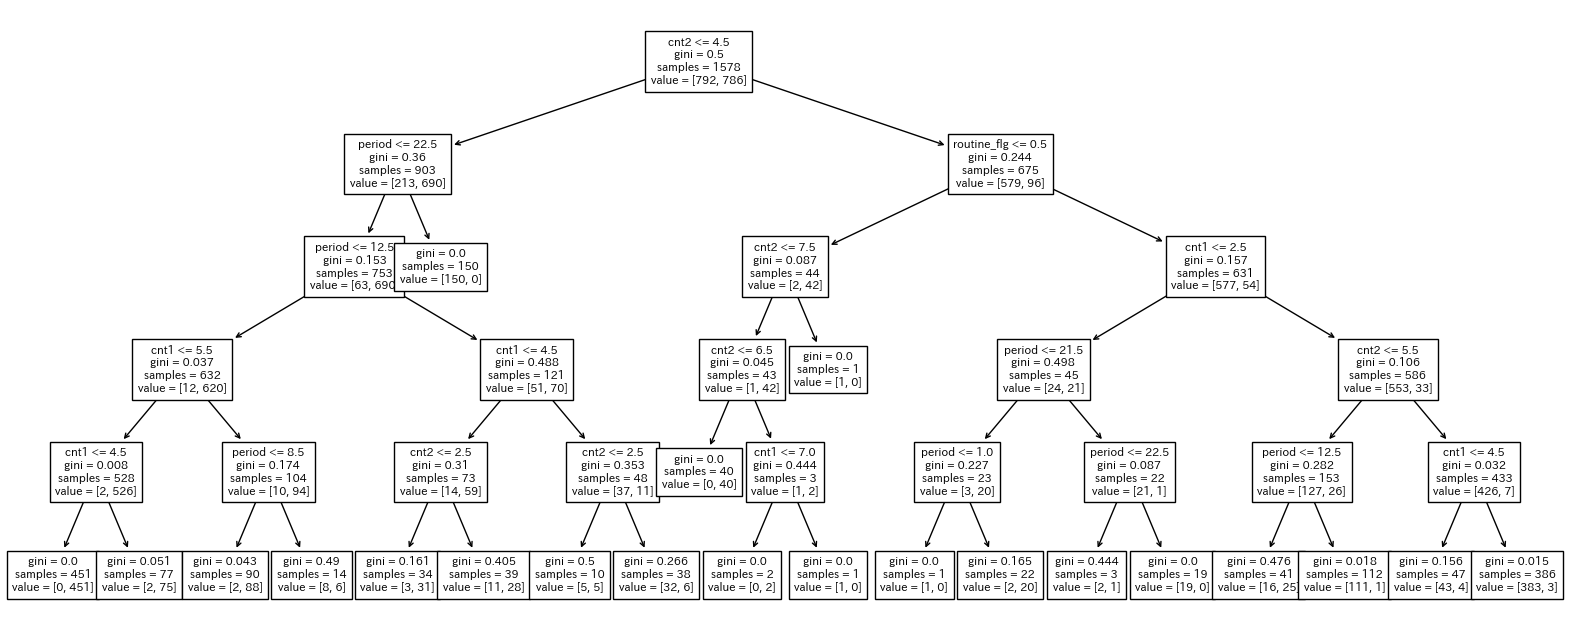

In [32]:
!pip install japanize_matplotlib
from sklearn import tree
import matplotlib.pyplot as plt
import japanize_matplotlib
%matplotlib inline

plt.figure(figsize=(20,8))
tree.plot_tree(model2,feature_names=X.columns,fontsize=8)

### ノック50：顧客の退会を予測しよう

In [39]:
input_data =[[0,3,1,5,0,0,1,0,0]]

data = pd.DataFrame(input_data,columns=X.columns)
print(model2.predict(data))
print(model2.predict_proba(data))

[1.]
[[0. 1.]]
